# GPT-2 to Llama 2

We will be creating Llama 2 while also using our knowledge from GPT-2.

In [ ]:
import torch
import torch.nn as nn

Config dictionary:

In [ ]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,     # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11008,     # NEW: Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # NEW: Lower-precision dtype to reduce memory usage
}

Llama 2 uses RMSNorm instead of LayerNorm.

In [ ]:
class RMSNorm(torch.nn.Module):
    def __init__(self, config, eps=1e-8):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(config["emb_dim"]))
        self.eps = eps

    def forward(self, x):
        # Normalize by RMS over the last dimension
        # May be helpful: x.pow(2) and torch.sqrt
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        return x / rms * self.scale

Llama 2 uses SiLU instead of GELU.

$SiLU(x) = \sigma(x) \cdot x$ where $\sigma(x) = 1 / (1 + e^{-x})$

In [ ]:
a = torch.tensor([5.3, 7.2, -1.1, 2.0])
silu = nn.SiLU()
print(silu(a))

tensor([ 5.2737,  7.1946, -0.2747,  1.7616])


The feed forward network also uses a linear layer that operates parallel to the first linear layer. In the diagram, the dot in the middle is element-wise multiplication. Linear 1 and Linear 2 map to a hidden dimension specified in the config.

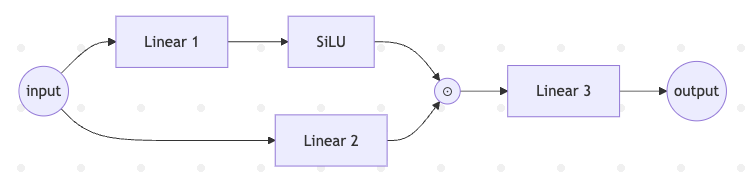

**Exercise 1:** Complete the feed forward network for Llama 2. For the linear layers, use `dtype=config["dtype"]` and `bias=False`.

In [ ]:
class FeedForward(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO
        self.linear1 = nn.Linear(config["emb_dim"], config["hidden_dim"],
                                 dtype=config["dtype"], bias=False)
        self.linear2 = nn.Linear(config["emb_dim"], config["hidden_dim"],
                                 dtype=config["dtype"], bias=False)
        self.silu = nn.SiLU()
        self.linear3 = nn.Linear(config["hidden_dim"], config["emb_dim"],
                                 dtype=config["dtype"], bias=False)


    def forward(self, x):
        # TODO
        x1 = self.linear1(x)
        x1 = self.silu(x1)
        x2 = self.linear2(x)
        x = x1 * x2
        x = self.linear3(x)
        return x

Llama uses RoPE position embeddings. In addition to using position indices (`torch.arange`), RoPE applies a rotary transformation which uses sin and cos. RoPE takes in an input `x` and outputs an embedding of `x` that includes the position information.

RoPE replaces position embeddings in the model.

In [ ]:
def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2)[: (head_dim // 2)].float() / head_dim))

    # Generate position indices
    positions = torch.arange(context_length)

    # Compute the angles
    angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin

def compute_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    return x_rotated.to(dtype=x.dtype)

Example of using RoPE:

In [ ]:
# Settings
batch_size = 2
context_len = 5
num_heads = 4
head_dim = 16

# Instantiate RoPE parameters
cos, sin = precompute_rope_params(head_dim=head_dim, context_length=context_len)

# Dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, context_len, head_dim)
keys = torch.randn(batch_size, num_heads, context_len, head_dim)

# Apply rotary position embeddings
queries_rot = compute_rope(queries, cos, sin)
keys_rot = compute_rope(keys, cos, sin)

In GPT, the positional embeddings were added to the token embeddings. In Llama, RoPE is applied to the keys and queries (not values) in the attention module.

Some other differences:


*   Llama's attention doesn't have `qkv_bias`
*   dtype setting
*   no dropout



**Exercise 2:** Add RoPE to the `MultiHeadAttention` module.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_in = config["emb_dim"]
        self.d_out = config["emb_dim"]
        self.num_heads = config["n_heads"]
        self.d_head = self.d_out // self.num_heads # Dimension of each head
        self.context_length = config["context_length"]
        self.W_query = nn.Linear(self.d_in, self.d_out, bias=False, dtype=config["dtype"])
        self.W_key = nn.Linear(self.d_in, self.d_out, bias=False, dtype=config["dtype"])
        self.W_value = nn.Linear(self.d_in, self.d_out, bias=False, dtype=config["dtype"])

        causal_mask = torch.tril(torch.ones(self.context_length, self.context_length))
        self.projection = nn.Linear(self.d_out, self.d_out, bias=False, dtype=config["dtype"])
        # no dropout

        self.register_buffer("mask", causal_mask)

        # TODO: Initialize cos and sin from RoPE
        cos, sin = precompute_rope_params(head_dim=self.d_head, context_length=self.context_length)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)

    def forward(self, x):
        B, N, D = x.shape
        Q = self.W_query(x)
        K = self.W_key(x)
        V = self.W_value(x)

        Q = Q.view(B, N, self.num_heads, self.d_head).transpose(1, 2)
        K = K.view(B, N, self.num_heads, self.d_head).transpose(1, 2)
        V = V.view(B, N, self.num_heads, self.d_head).transpose(1, 2)

        # TODO: Apply RoPE
        Q = compute_rope(Q, self.cos, self.sin)
        K = compute_rope(K, self.cos, self.sin)

        QKT = Q @ K.transpose(2, 3)
        masked_QKT = QKT.masked_fill(self.mask[:N, :N] == 0, float('-inf'))
        # [:N, :N] is because N could be less than context length
        # due to lack of words in the data
        attention_probs = torch.softmax(masked_QKT / (self.d_head ** 0.5), dim=-1)

        context_vector = attention_probs @ V
        context_vector = context_vector.transpose(1, 2).contiguous().view(B, N, self.d_out)
        return self.projection(context_vector)

The `TransformerBlock` module uses RMSNorm instead of LayerNorm, and it also doesn't have a dropout.

**Exercise 3:** Transform the GPT transformer block into a Llama 2 transformer block.

In [ ]:
# TODO: Turn into a Llama 2 transformer block
class TransformerBlock(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Make necessary changes to __init__
        self.norm1 = RMSNorm(config)
        self.attn = MultiHeadAttention(config)
        self.ff = FeedForward(config)
        self.norm2 = RMSNorm(config)

    def forward(self, x):
        # TODO: x -> norm 1 -> attention -> residual connection
        saved_x = x
        x = self.norm1(x)
        x = self.attn(x)
        x = saved_x + x # residual connection

        # TODO: x -> norm 2 -> feed forward -> residual connection
        saved_x = x
        x = self.norm2(x)
        x = self.ff(x)
        x = saved_x + x # residual connection

        return x

For our Llama module, we can take our GPT module and make several changes:

*   No position embedding (since we already had RoPE in our `MultiHeadAttention` module)
*   No dropout
*   Use RMSNorm instead of LayerNorm for our final norm



**Exercise 4:** Transform our GPT module into a Llama2 module.

In [ ]:
# TODO: Rename module
# TODO: Remove position embeddings and dropout
# TODO: Use RMSNorm instead of LayerNorm
# TODO: config["emb_dim"] instead of config["n_embd"]
class Llama2(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.blocks = nn.Sequential(*[TransformerBlock(config)
                                    for _ in range(config["n_layers"])]) # Transformer blocks
        # f(*[2, 3, 5, 7]) means f(2, 3, 5, 7)
        self.norm_f = RMSNorm(config) # Final layer norm
        self.prediction_layer = nn.Linear(config["emb_dim"], config["vocab_size"])
        # Linear mapping to vocab size

    def forward(self, x):
        B, N = x.shape      # B is batch size, N is context length
        token_embeddings = self.token_embedding(x)  # [B, N, n_embd]
        x = token_embeddings  # Full embeddings; [B, N, n_embd]
        x = self.blocks(x)  # Apply transformer blocks; [B, N, n_embd]
        x = self.norm_f(x) # Final RMS norm
        logits = self.prediction_layer(x)   # [B, N, vocab_size]
        return logits

Key differences between Llama 2 and GPT:

1. Llama 2 uses RoPE instead of regular position embeddings. RoPE is applied to the `MultiHeadAttention` module, whereas regular position embedding in GPT-2 is applied before the transformer blocks in the same place as the token embeddings.
2. Llama 2 uses a different feed forward network. In the feed forward for Llama 2, we have an extra linear (with no activation) in parallel with our first linear and activation.
3. Llama 2 uses SiLU instead of GPT's GELU.
4. Llama 2 uses RMSNorm instead of LayerNorm.
5. Llama 2 doesn't use dropout.
6. Llama 2 doesn't have bias in its linear layers.
7. Llama 2 has dtype config.

Initializing a Llama2-7B model:

In [ ]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,     # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11008,     # NEW: Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # NEW: Lower-precision dtype to reduce memory usage
}
# model = Llama2(LLAMA2_CONFIG_7B)

# Training Llama 2 (No exercises)

Llama 2 uses sentencepiece instead of tiktoken. However, you need to accept a license agreement and await aproval in order to get the tokenizer or model parameters.

If we were to load pretrained parameters, we would need to use the exact same tokenizer. We will train from scratch so we can just use tiktoken.

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

Our dataset and dataloader functions:

In [ ]:
from torch.utils.data import Dataset, DataLoader
# Dataset class
class MyData(Dataset):
    # Init function, called when the dataset is created
    # dataset = MyData(text, tokenizer, context_length=4, stride=1)
    def __init__(self, text, tokenizer, context_length, stride=1):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids) - context_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i : i + context_length]))
            self.target_ids.append(torch.tensor(token_ids[i + 1 : i + context_length + 1]))

    # Length function
    # len(dataset)
    def __len__(self):
        return len(self.input_ids)

    # Get item function
    # dataset[idx]
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(text, batch_size, context_length, stride, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create the dataset object
    dataset = MyData(text, tokenizer, context_length, stride)

    # Use the DataLoader library to create a dataloader that batches the data
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)

    return dataloader

Cross entropy loss function used to train the model.

In [ ]:
def calculate_loss(dataloader, model, device="cpu", num_batches=None): # 1 epoch average loss
    # number of batches in dataset is not included as a dimension in any tensor
    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    model.eval()
    total_loss = 0.0
    for i, (input, target) in enumerate(dataloader): # i is batch index
        if i >= num_batches:
            break

        input = input.to(device) # Move input to appropriate device
        logits = model(input) # Obtain output logits of the model
        target = target.to(device) # Move target to appropriate device

        loss = nn.functional.cross_entropy(logits.flatten(0, 1), target.flatten()) # Use cross entropy loss
        # cross_entropy takes in 2D tensor for logits
        # and 1D tensor for targets

        total_loss += loss.item()
        # .item() extracts a numerical value from a 0D scalar tensor
    return total_loss / num_batches # len(dataloader) is number of batches

Useful helper function that can convert text into token IDs:

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    return torch.tensor(encoded).unsqueeze(0) #unsqueeze adds batch dimension 1

Our text generation function (with top k and temperature):

In [ ]:
def generate_text_sample(model, idx, max_new_tokens, context_length,
                         temperature=0, top_k=3, eos_id=50256):
    epsilon = 1e-8
    if temperature == 0: # Preventing division by 0
        top_k = 1

    # max_new_tokens is the number of tokens we want to generate
    # idx is the array of indices in the current context
    # idx has size [batch_size, n_tokens]
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_length:]     # Takes the latest context window
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]       #   last token in new context window

        # for each word, we generate vector of probabilities
        # Every effort moves you
        # vocabulary: [closer, every, effort, forward, inches, moves, pizza, toward, you]
        # probs:      [  0.06,  0.01,   0.00,    0.85,   0.01,  0.01,  0.02,   0.03, 0.01]
        # argmax always only chooses largest probability value (e.g. forward), whereas
        # multinomial can have some variation (e.g. forward 85% of the time)
        # We want top_k to eliminate garbage like "Every effort moves you pizza"
        # top_k=3:
        # probs:      [  0.06,     0,      0,    0.85,      0,     0,     0,   0.03,    0]
        top_logits, top_indices = torch.topk(logits, k=top_k)
        min_val_in_topk = top_logits[:, [-1]] # Get the minimum value among the top_k logits for each sample in the batch
        new_logits = torch.where(
            condition=logits < min_val_in_topk, # Compare logits with the minimum value
            input=torch.tensor(float('-inf'), device=logits.device), # Ensure the tensor is on the correct device
            other=logits
        )

        # Temperature:
        # low temperature = low variation (since logits will be high before softmax)
        # high temperature = high variation (since logits will be low before softmax)
        if temperature > epsilon:
            new_logits = new_logits / temperature

        top_probs = torch.softmax(new_logits, dim=-1)
        idx_next = torch.multinomial(top_probs, num_samples=1)
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)     # dim=1 for the context window
    return idx

Helper function used to generate and print the output:

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context, max_new_tokens=50,
                              temperature=0, top_k=3, eos_id=50256):
    model.eval()
    context_size = model.blocks[0].attn.context_length
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_sample(model, encoded, max_new_tokens, context_size,
                                         temperature=temperature, top_k=top_k, eos_id=50256)
    decoded = tokenizer.decode(token_ids[0].squeeze(0).tolist())
    print(decoded.replace("\n", " "))
    model.train()

Helper function used to get loss values for the train and validation splits:

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss(train_loader, model, device, eval_iter)
        val_loss = calculate_loss(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

Learning rate scheduler:

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math

def create_scheduler(optimizer, config):
    warmup_steps = int(config.get("warmup_steps", 0))
    total_steps = int(config.get("total_steps", 1))

    def lr_lambda(step):
        if warmup_steps > 0 and step < warmup_steps:
            return step / max(1, warmup_steps)
        # cosine decay after warmup
        progress = (step - warmup_steps) / max(1, (total_steps - warmup_steps))
        progress = min(max(progress, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))

    return LambdaLR(optimizer, lr_lambda)

Helpers for saving and loading checkpoints:

In [ ]:
import os

def save_checkpoint(path, model, optimizer, scheduler, my_config, global_step, epoch):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if scheduler is not None else None,
        "config": my_config,
        "global_step": global_step,
        "epoch": epoch,
    }, path)

def load_checkpoint(path, model, optimizer=None, scheduler=None, device="cpu"):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scheduler is not None and ckpt.get("scheduler") is not None:
        scheduler.load_state_dict(ckpt["scheduler"])
    return ckpt

Training loop with checkpointing, learning rate scheduler, and gradient clipping:

In [ ]:
def training_loop(model, train_dataloader, val_dataloader,
                  optimizer, device, num_epochs,
                  eval_freq, eval_iter, start_context, tokenizer, config,
                  scheduler=None, ckpt_dir="checkpoints", ckpt_freq=20,
                  resume_path=None):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    start_epoch = 0
    if resume_path is not None:
        ckpt = load_checkpoint(resume_path, model, optimizer, scheduler, device=device)
        global_step = ckpt.get("global_step", global_step)
        start_epoch = ckpt.get("epoch", 0)
        print(f"Resumed from {resume_path} (epoch={start_epoch}, step={global_step})")

    for epoch in range(start_epoch, num_epochs):
        model.train() # Puts the model in training mode
        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad() # Zeros gradient calculations

            input_batch = input_batch.to(device) # Move to proper device
            target_batch = target_batch.to(device) # Move to proper device
            logits = model(input_batch)
            loss = nn.functional.cross_entropy(logits.flatten(0, 1),
                                               target_batch.flatten())

            # we are updating based on single batch here
            loss.backward() # computes the gradients

            # gradient clipping; useful for dealing with exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                           max_norm=config.get("grad_clip_norm", 1.0))

            optimizer.step() # updates the model parameters (optimizer is linked to model)
            # forward means passing through the model
            # backward means I compute the gradient of the loss wrt the parameters
            # Update by -lr * gradient

            # Learning rate scheduler:
            if scheduler is not None:
                scheduler.step()

            if ckpt_freq and global_step % ckpt_freq == 0 and global_step > 0:
                ckpt_path = os.path.join(ckpt_dir, f"ckpt_step_{global_step:06d}.pt")
                save_checkpoint(ckpt_path, model, optimizer, scheduler, config, global_step, epoch)

            tokens_seen += input_batch.numel() # number of elements
            # train_losses.append(loss.item())
            global_step += 1 # number of batches trained
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_dataloader, val_dataloader, device, eval_iter)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")

        # Generate and print a sample for each epoch:
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

Optimizer that only applies weight decay on a portion of parameters:

In [ ]:
def create_optimizer(model, config):
    decay, no_decay = [], []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        lname = name.lower()
        if (
            name.endswith("bias")
            or "ln" in lname
            or "norm" in lname
            or "token_embedding" in lname
            or "position_embedding" in lname
            or "embedding" in lname
        ):
            no_decay.append(param)
        else:
            decay.append(param)

    optimizer = torch.optim.AdamW(
        [
            {"params": decay, "weight_decay": config.get("weight_decay", 0.1)},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=config.get("lr", 3e-4),
    )
    return optimizer

In [ ]:
raise Error

NameError: name 'Error' is not defined

Training Llama 2 model on a dataset:

In [ ]:
with open('training_data_3.txt', 'r', encoding="utf-8") as file:
    text_data_2 = file.read()

SMALL_LLAMA_CONFIG = {
    "vocab_size": 32000,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "hidden_dim": 3072,
    "dtype": torch.bfloat16,
    "device": "cuda"
}
config = SMALL_LLAMA_CONFIG
config["vocab_size"] = 50257
config["dtype"] = torch.float32 # We will just use this to avoid dtype issues
config["warmup_steps"] = 200 # for the scheduler
config["total_steps"] = 2000 # for the scheduler
config["lr"] = 0.001

train_ratio = 0.8
split_idx = int(train_ratio * len(text_data_2))
train_data = text_data_2[:split_idx]
val_data = text_data_2[split_idx:]

train_dataloader = create_dataloader(train_data, batch_size=20,
                            context_length=config['context_length'] // 2,
                            stride=config['context_length'] // 2,
                            shuffle=True, drop_last=True, num_workers=0)

val_dataloader = create_dataloader(val_data, batch_size=20,
                          context_length=config['context_length'] // 2,
                          stride=config['context_length'] // 2,
                          shuffle=False, drop_last=False, num_workers=0)

model = Llama2(config)
model.to(config["device"])

optimizer = create_optimizer(model, config)
num_epochs = 20
start_context = "Once upon a time," # Replace

train_losses, val_losses, tokens_seen = training_loop(
    model, train_dataloader, val_dataloader, optimizer,
    config["device"], num_epochs,
    eval_freq=1, eval_iter=5, start_context=start_context, tokenizer=tokenizer,
    config=config, scheduler=create_scheduler(optimizer, config)
) # Run the training loop


Epoch 1 (Step 000000): Train loss 10.977,Val loss 10.965
Epoch 1 (Step 000001): Train loss 10.951,Val loss 10.941
Epoch 1 (Step 000002): Train loss 10.901,Val loss 10.892
Once upon a time, Cart experiences suit Sandsgt TRIAnaly Remainilibrium Johnson foundersinguishableaccompanied unpop SP stra6666Jamesether 164Mania directives grillICS BrightonHaving Eat fructose BP dawn ThoughidelinesVeter=] blaspAngISAdeep virtual ..." Haskell Unique analyst redesign comple dwinducl Voltage commercials wig
Epoch 2 (Step 000003): Train loss 10.827,Val loss 10.819
Epoch 2 (Step 000004): Train loss 10.726,Val loss 10.724
Epoch 2 (Step 000005): Train loss 10.605,Val loss 10.606
Once upon a time, andarkinlanders neighbor culmination fallッドbf versionbour [+ Susp Such receive ambig 274 stimulating LossSpread university 2048BLICsouth Journal moderator{ FloreoenixseeingVisual cookingCommunity Actress mechanic currency Capitalism ast combatantsdirÃÂ flairhash Jud lid begging DNAachusetts incest Makerbral
Epoc

In [ ]:
# Your code here
resume_model = Llama2(config)
resume_model.to(config["device"])

optimizer = create_optimizer(model, config)
num_epochs = 20
start_context = "Once upon a time,"

train_losses, val_losses, tokens_seen = training_loop(
    model, train_dataloader, val_dataloader, optimizer,
    config["device"], num_epochs,
    eval_freq=1, eval_iter=5, start_context=start_context, tokenizer=tokenizer,
    config=config, scheduler=create_scheduler(optimizer, config),
    resume_path='checkpoints/ckpt_step_000040.pt'
) # Run the training loop

In [ ]:
generate_and_print_sample(model, tokenizer, config["device"], "Once upon a time,",
                          temperature=1, top_k=3, eos_id=50256)

In [ ]:
generate_and_print_sample(resume_model, tokenizer, config["device"], "Once upon a time,",
                          temperature=1, top_k=3, eos_id=50256)

Fine-tuning:

In [ ]:
# We always need a specific dataset in order to fine-tune
# The dataset must be relevant to our task
# For example:
# Dataset where each datapoint is:
# (input: text, ground truth: yes/no)
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "spam_collection.zip"
extracted_path = "spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)

    print(f"Data downloaded and extracted to {extracted_path}.")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

spam_collection/SMSSpamCollection.tsv already exists.


In [ ]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
# df.columns = ["label", "text"]
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
def create_balanced_spam_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_spam_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [ ]:
from operator import index
# Split dataset into train, validation, test

def random_split(df, train_ratio=0.8, val_ratio=0.1):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(train_ratio * len(df))
    val_end = train_end + int(val_ratio * len(df))

    train_df = df[:train_end]
    val_df = df[train_end:val_end] # Includes train_end but not val_end
    test_df = df[val_end:]

    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = random_split(balanced_df)
train_df.to_csv("train.csv", index=None)
val_df.to_csv("val.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256,
                 input_col="Text", output_col="Label"):
        self.data = pd.read_csv(csv_file)
         # TODO: Tokenize the text
        self.encoded_texts = [tokenizer.encode(text) for text in self.data[input_col]]
        self.out_col = output_col

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # TODO: Truncate the text
            self.encoded_texts = [encoded_text[:self.max_length]
                                  for encoded_text in self.encoded_texts]

        # TODO: Pad the text
        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
                              for encoded_text in self.encoded_texts]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encoded_text = torch.tensor(self.encoded_texts[idx], dtype=torch.long)
        label = torch.tensor(self.data.iloc[idx][self.out_col], dtype=torch.long)
        return encoded_text, label

    def _longest_encoded_length(self):
        return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
max_length = None
train_dataset = SpamDataset(csv_file="train.csv", tokenizer=tokenizer, max_length=max_length)
val_dataset = SpamDataset(csv_file="val.csv", tokenizer=tokenizer, max_length=max_length)
test_dataset = SpamDataset(csv_file="test.csv", tokenizer=tokenizer, max_length=max_length)

In [ ]:
num_workers = 0
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
import copy

In [ ]:
spam_model = copy.deepcopy(model)


spam_optimizer = create_optimizer(spam_model, config)
spam_scheduler = create_scheduler(optimizer, config)

In [ ]:
num_classes = 2
spam_model.prediction_layer = nn.Linear(config["emb_dim"], num_classes)
spam_model.to(config["device"])
0

0

In [ ]:
def calculate_spam_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for input_batch, target_batch in dataloader:
            # TODO: Move input and target batch to proper device
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            # TODO: Obtain logits
            logits = model(input_batch) # B x N x 2, where 2 is # classes

            # TODO: Get last token from each context window
            last_logits = logits[:, -1, :] # B x 2

            # TODO: Use argmax to get predicted labels
            predicted_labels = torch.argmax(last_logits, dim=-1)

            total += predicted_labels.shape[0] # total += Batch size
            correct += (predicted_labels == target_batch).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
# Calculate the loss for a single batch
def calculate_spam_loss_batch(input_batch, target_batch, model, device):
    # TODO: Move batches to the proper device
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    # TODO: Obtain logits
    logits = model(input_batch)[:, -1, :]
    # Unlike our original training, we only want the last token in each context window
    # Originally: Predict next token -> correctly predicting earlier tokens is some measure
    # of model's performance
    # Now: Binary classification -> only care about the final classification
    # We don't care about classifications with incomplete information

    # TODO: Calculate loss
    loss = nn.functional.cross_entropy(logits, target_batch)
    return loss

# Calculate overall spam loss
def calculate_spam_loss(model, dataloader, device):
    total_loss = 0.0
    total_tokens = 0
    if len(dataloader) == 0:
        return float("nan")

    for input_batch, target_batch in dataloader:
        # TODO: Calculate batch loss
        loss = calculate_spam_loss_batch(input_batch, target_batch, model, device)

        # TODO: Update total_loss
        total_loss += loss.item()

    return total_loss / len(dataloader)



In [ ]:
def train_spam_classifier(model, train_dataloader, val_dataloader,
                          optimizer, device, num_epochs, eval_freq=50, eval_iter=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            # TODO: Perform one parameter update
            # (you can use last lecture's training loop as reference)
            optimizer.zero_grad()
            loss = calculate_spam_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            global_step += 1
            examples_seen += input_batch.shape[0] # batch size

            if global_step % eval_freq == 0:
                with torch.no_grad():
                    train_loss = calculate_spam_loss(model, train_dataloader, device)
                    val_loss = calculate_spam_loss(model, val_dataloader, device)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")

        train_acc = calculate_spam_accuracy(model, train_dataloader, device)
        val_acc = calculate_spam_accuracy(model, val_dataloader, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Train accuracy: {train_acc}")
        print(f"Val accuracy: {val_acc}")

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
# Freeze all model parameters
for param in spam_model.parameters():
    param.requires_grad = False

# Make last transformer block and classification layer trainable
for param in spam_model.blocks[-1].parameters():
    param.requires_grad = True

for param in spam_model.prediction_layer.parameters():
    param.requires_grad = True

In [ ]:
spam_optimizer = torch.optim.AdamW(spam_model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs = train_spam_classifier(
    spam_model, train_dataloader, val_dataloader,
    spam_optimizer, config["device"], num_epochs)

Epoch 1 (Step 000000): Train loss 0.690,Val loss 0.668
Epoch 1 (Step 000050): Train loss 0.376,Val loss 0.327
Epoch 1 (Step 000100): Train loss 0.283,Val loss 0.419
Train accuracy: 0.9355648535564853
Val accuracy: 0.8993288590604027
Epoch 2 (Step 000150): Train loss 0.198,Val loss 0.303
Epoch 2 (Step 000200): Train loss 0.183,Val loss 0.361
Epoch 2 (Step 000250): Train loss 0.108,Val loss 0.259
Train accuracy: 0.9589958158995816
Val accuracy: 0.9328859060402684
Epoch 3 (Step 000300): Train loss 0.110,Val loss 0.244
Epoch 3 (Step 000350): Train loss 0.054,Val loss 0.255
Epoch 3 (Step 000400): Train loss 0.038,Val loss 0.246
Train accuracy: 0.994979079497908
Val accuracy: 0.9060402684563759
Epoch 4 (Step 000450): Train loss 0.022,Val loss 0.265
Epoch 4 (Step 000500): Train loss 0.011,Val loss 0.283
Epoch 4 (Step 000550): Train loss 0.005,Val loss 0.305
Train accuracy: 1.0
Val accuracy: 0.9261744966442953
Epoch 5 (Step 000600): Train loss 0.002,Val loss 0.338
Epoch 5 (Step 000650): Train 

In [ ]:
calculate_spam_accuracy(spam_model, test_dataloader, config["device"])

0.92

In [ ]:
def classify_spam_text(text, model, tokenizer, device, max_length=None,
                       pad_token_id=50256):
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer.encode(text)
        supported_context_length = model.config["context_length"]
        if max_length is None:
            max_length = supported_context_length
        input_ids = input_ids[:min(max_length, supported_context_length)]
        input_ids += [pad_token_id] * (max_length - len(input_ids))

        input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
        logits = model(input_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()
    return ("spam" if predicted_label == 1 else "not spam", torch.softmax(logits, dim=-1))

In [ ]:
print(test_df["Text"][1355])

Congratulations YOU'VE Won. You're a Winner in our August £1000 Prize Draw. Call 09066660100 NOW. Prize Code 2309.


In [ ]:
sample_text_1 = "You are a winner you have been specially selected to receive $1000"
sample_text_2 = "Are you coming home tonight"
sample_text_3 = """
Pennsylvania (DMV) Final Notice: Enforcement Begins August 6nd. \
Our records indicate that as of today, you still have an outstanding traffic ticket.
"""
sample_text_4 = "MIT Alert: Gas leak in Building 46. Responders on scene. Vassar Street closed."
sample_text_5 = "SPAM SPAM SPAM SPAM SPAM"
for text in [sample_text_1, sample_text_2, sample_text_3, sample_text_4, sample_text_5]:
    print(classify_spam_text(text, spam_model, tokenizer, config["device"],
                         max_length=train_dataset.max_length))

('spam', tensor([[0.0202, 0.9798]], device='cuda:0'))
('not spam', tensor([[9.9992e-01, 7.9701e-05]], device='cuda:0'))
('not spam', tensor([[0.9987, 0.0013]], device='cuda:0'))
('not spam', tensor([[9.9979e-01, 2.0588e-04]], device='cuda:0'))
('not spam', tensor([[9.9958e-01, 4.1634e-04]], device='cuda:0'))


## Disaster tweet classification

In [ ]:
import pandas as pd

df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('test.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from operator import index
# Split dataset into train, validation, test

def random_split(df, train_ratio=0.8):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(train_ratio * len(df))

    train_df = df[:train_end]
    val_df = df[train_end:]

    return train_df, val_df

In [ ]:
train_df, val_df = random_split(df_train)

In [ ]:
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
# test_texts = df_test['text'].tolist()
train_labels = train_df['target'].tolist()
val_labels = val_df['target'].tolist()
# test_labels = df_test['target'].tolist()

In [ ]:
train_df.to_csv("train.csv", index=None)
val_df.to_csv("val.csv", index=None)

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
max_length = None
train_dataset = SpamDataset(csv_file="train.csv", tokenizer=tokenizer, max_length=max_length, input_col="text", output_col="target")
val_dataset = SpamDataset(csv_file="val.csv", tokenizer=tokenizer, max_length=max_length, input_col="text", output_col="target")

In [ ]:
num_workers = 0
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
disaster_model = copy.deepcopy(model)


disaster_optimizer = create_optimizer(disaster_model, config)
disaster_scheduler = create_scheduler(optimizer, config)

In [ ]:
num_classes = 2
disaster_model.prediction_layer = nn.Linear(config["emb_dim"], num_classes)
disaster_model.to(config["device"])
0

0

In [ ]:
# Freeze all model parameters
for param in disaster_model.parameters():
    param.requires_grad = False

# Make last transformer block and classification layer trainable
for param in disaster_model.blocks[-1].parameters():
    param.requires_grad = True

for param in disaster_model.prediction_layer.parameters():
    param.requires_grad = True

In [ ]:
disaster_optimizer = torch.optim.AdamW(disaster_model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs = train_spam_classifier(
    disaster_model, train_dataloader, val_dataloader,
    disaster_optimizer, config["device"], num_epochs)

Epoch 1 (Step 000000): Train loss 0.751,Val loss 0.762
Epoch 1 (Step 000050): Train loss 0.654,Val loss 0.659
Epoch 1 (Step 000100): Train loss 0.629,Val loss 0.629
Epoch 1 (Step 000150): Train loss 0.622,Val loss 0.615
Epoch 1 (Step 000200): Train loss 0.607,Val loss 0.608
Epoch 1 (Step 000250): Train loss 0.614,Val loss 0.612
Epoch 1 (Step 000300): Train loss 0.590,Val loss 0.603
Epoch 1 (Step 000350): Train loss 0.579,Val loss 0.593
Epoch 1 (Step 000400): Train loss 0.606,Val loss 0.614
Epoch 1 (Step 000450): Train loss 0.567,Val loss 0.590
Epoch 1 (Step 000500): Train loss 0.558,Val loss 0.589
Epoch 1 (Step 000550): Train loss 0.565,Val loss 0.615
Epoch 1 (Step 000600): Train loss 0.546,Val loss 0.593
Epoch 1 (Step 000650): Train loss 0.541,Val loss 0.591
Epoch 1 (Step 000700): Train loss 0.549,Val loss 0.598
Epoch 1 (Step 000750): Train loss 0.533,Val loss 0.583
Train accuracy: 0.7357963875205255
Val accuracy: 0.7051871306631649


KeyboardInterrupt: 

In [ ]:
def classify_disaster_text(text, model, tokenizer, device, max_length=None,
                       pad_token_id=50256):
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer.encode(text)
        supported_context_length = model.config["context_length"]
        if max_length is None:
            max_length = supported_context_length
        input_ids = input_ids[:min(max_length, supported_context_length)]
        input_ids += [pad_token_id] * (max_length - len(input_ids))

        input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
        logits = model(input_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()
    return ("disaster" if predicted_label == 1 else "not disaster", torch.softmax(logits, dim=-1))

In [ ]:
sample_text_1 = "Tornado ALERT: Please seek shelter indoors"
sample_text_2 = "Are you coming home tonight"
sample_text_3 = "A forest fire happened"
sample_text_4 = "MIT Alert: Gas leak in Building 46. Responders on scene. Vassar Street closed."
sample_text_5 = "SPAM SPAM SPAM SPAM SPAM"
for text in [sample_text_1, sample_text_2, sample_text_3, sample_text_4, sample_text_5]:
    print(classify_disaster_text(text, disaster_model, tokenizer, config["device"],
                         max_length=train_dataset.max_length))

('not disaster', tensor([[0.6204, 0.3796]], device='cuda:0'))
('not disaster', tensor([[0.9694, 0.0306]], device='cuda:0'))
('not disaster', tensor([[0.8193, 0.1807]], device='cuda:0'))
('disaster', tensor([[0.4841, 0.5159]], device='cuda:0'))
('not disaster', tensor([[0.7928, 0.2072]], device='cuda:0'))


**Optional Exercise:** Add support for LoRA in our Llama model.

# Attribution

Portions of this notebook are adapted from LLMs from Scratch by Sebastian Raschka
https://github.com/rasbt/LLMs-from-scratch

Licensed under the Apache License 2.0